In [1]:
import pandas as pd

In [60]:
country_wise= pd.read_csv('country_wise_latest.csv')
covid19_clean= pd.read_csv('covid_19_clean_complete.csv')
day_wise= pd.read_csv('day_wise.csv')
full_grouped= pd.read_csv('full_grouped.csv')
usa_county_wise= pd.read_csv('usa_county_wise.csv')
worldometer= pd.read_csv('worldometer_data.csv')

# Create bar charts comparing case numbers between continents

In [37]:
continent= worldometer.groupby('Continent')['TotalCases'].sum().reset_index()
continent.set_index('Continent')
continent=continent.sort_values(by='TotalCases', ascending=False)


<Axes: xlabel='Continent'>

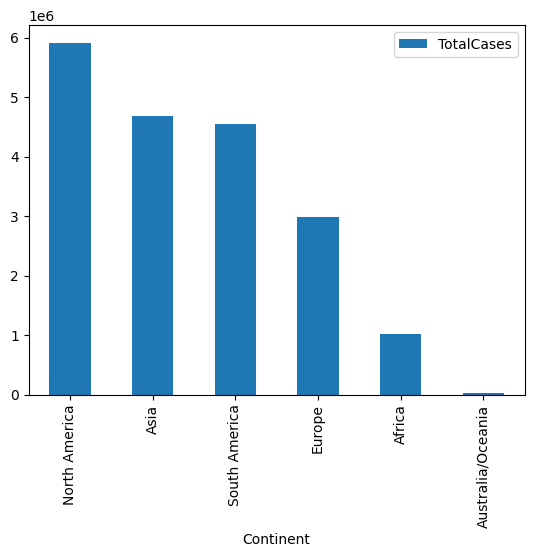

In [38]:
continent.plot(kind='bar',x='Continent',y='TotalCases')

# Visualize state-wise death or active cases in a country like the USA.

In [39]:
use_state_wise=usa_county_wise.groupby(['Date','Province_State']).agg(total_deaths=('Deaths','sum')).reset_index()
use_state_wise

,Date,Province_State,total_deaths
0,1/22/20,Alabama,0
1,1/22/20,Alaska,0
2,1/22/20,American Samoa,0
3,1/22/20,Arizona,0
4,1/22/20,Arkansas,0
...,...,...,...
10899,7/9/20,Virginia,1937
10900,7/9/20,Washington,1409
10901,7/9/20,West Virginia,95
10902,7/9/20,Wisconsin,809


In [40]:
pivot_us=use_state_wise.pivot(index='Date', columns='Province_State', values='total_deaths')

<Axes: ylabel='Province_State'>

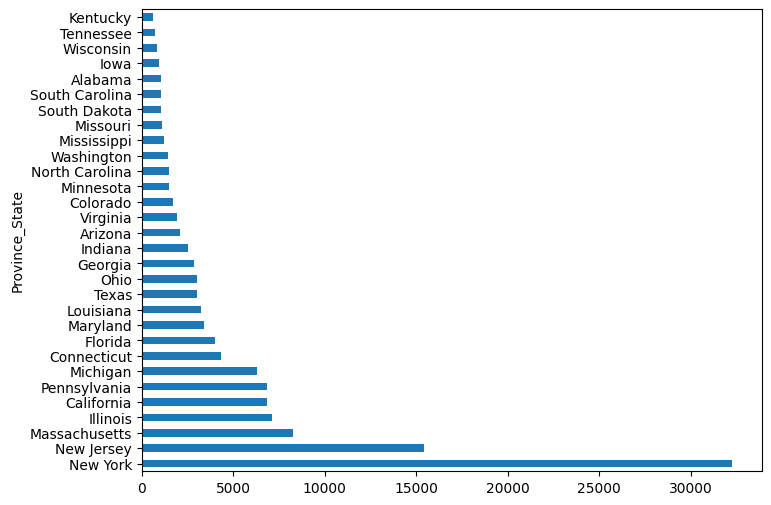

In [41]:
snap = pivot_us.iloc[-1].sort_values(ascending=False).head(30)

snap.plot(kind='barh', figsize=(8,6))

# Create heatmaps or choropleth maps to show case density geographically.


In [42]:
import seaborn as sns
case_density=worldometer.head(20)

In [43]:
df_pivot=case_density.pivot(index='Country/Region', columns='Continent', values='TotalCases')

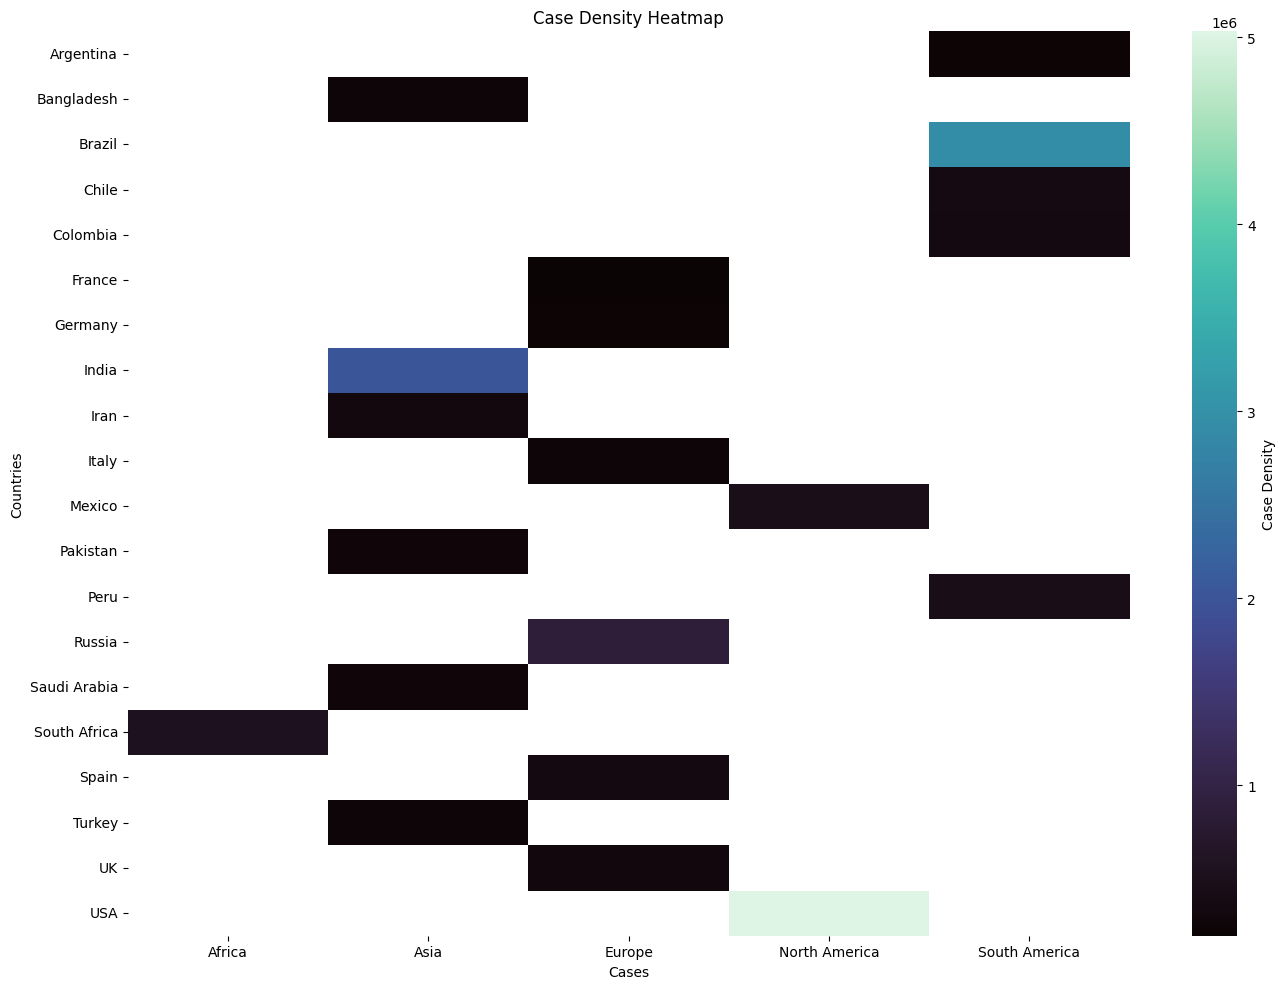

In [44]:
plt.figure(figsize=(14,10))
ax = sns.heatmap(
    df_pivot,
    cmap='mako',          # or 'viridis', 'crest', 'Blues'
    linewidths=0,         # thin lines: try 0.2 if you want separators
    linecolor='orange',
    cbar_kws={'label': 'Case Density'},
    square=False
)
ax.set_xlabel('Cases')
ax.set_ylabel('Countries')
ax.set_title('Case Density Heatmap')
plt.tight_layout()
plt.show()

# Create new features like active cases from confirmed, recovered, and deaths

In [45]:
active=worldometer[['Country/Region','TotalCases','TotalDeaths','TotalRecovered']]

In [46]:
active['Active_Cases']= active['TotalCases'] - active['TotalDeaths'] - active['TotalRecovered']

C:\Users\aayus\AppData\Local\Temp\ipykernel_10788\3581771665.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active['Active_Cases']= active['TotalCases'] - active['TotalDeaths'] - active['TotalRecovered']


In [47]:
active


,Country/Region,TotalCases,TotalDeaths,TotalRecovered,Active_Cases
0,USA,5032179,162804.0,2576668.0,2292707.0
1,Brazil,2917562,98644.0,2047660.0,771258.0
2,India,2025409,41638.0,1377384.0,606387.0
3,Russia,871894,14606.0,676357.0,180931.0
4,South Africa,538184,9604.0,387316.0,141264.0
...,...,...,...,...,...
204,Montserrat,13,1.0,10.0,2.0
205,Caribbean Netherlands,13,NaN,7.0,NaN
206,Falkland Islands,13,NaN,13.0,NaN
207,Vatican City,12,NaN,12.0,NaN


# Encode categorical variables like country and region for machine learning.


In [131]:
!pip install category_encoders

In [143]:
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import category_encoders as ce 
pred=full_grouped.groupby(['Country/Region', 'Date'])['New cases'].sum().reset_index()
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoder = OneHotEncoder()
country_encoded = onehot_encoder.fit_transform(pred[['Country/Region']])
import numpy as np
country_encoded_dense = country_encoded.toarray()

label_encoder = LabelEncoder()
pred['Country_encoded'] = label_encoder.fit_transform(pred['Country/Region'])


# Build a simple regression model to predict future case counts using historical data.



# Split the data into training and testing sets appropriately for time series data.


In [186]:
pred['Year'] = pred['Date'].dt.year
pred['Week'] = pred['Date'].dt.isocalendar().week
pred['Day_of_week'] = pred['Date'].dt.dayofweek
pred['Days_since_start'] = (pred['Date'] - pd.to_datetime('2020-01-01')).dt.days

pred['Cases_1week_ago'] = pred.groupby('Country_encoded')['New cases'].shift(7)
pred['Cases_2week_ago'] = pred.groupby('Country_encoded')['New cases'].shift(14)


pred['Cases_7day_avg'] = pred.groupby('Country_encoded')['New cases'].transform(
    lambda x: x.rolling(7, min_periods=1).mean())


pred['Growth_rate'] = pred.groupby('Country_encoded')['New cases'].pct_change(7)

pred.replace([np.inf, -np.inf], np.nan, inplace=True)
pred['Cases_1week_ago'].fillna(0, inplace=True)
pred['Cases_2week_ago'].fillna(0, inplace=True)
pred['Cases_7day_avg'].fillna(pred['Cases_7day_avg'].mean(), inplace=True)
pred['Growth_rate'].fillna(0, inplace=True)


X = pred[['Country_encoded', 'Month_num', 'Week', 'Year', 
          'Cases_1week_ago', 'Cases_2week_ago', 'Cases_7day_avg', 'Growth_rate']]
y = pred['New cases']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0, positive=True)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

C:\Users\aayus\AppData\Local\Temp\ipykernel_10788\392002277.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pred['Cases_1week_ago'].fillna(0, inplace=True)
C:\Users\aayus\AppData\Local\Temp\ipykernel_10788\392002277.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [187]:
print(predictions[:10])

[ 104.2225075  5675.71957648   10.41842613   24.29819993  427.06610209
  141.80305675  334.29893292 7780.43620706  188.66609236  154.92199433]


# Evaluate model performance with metrics like accuracy, precision, recall, or RMSE

In [189]:
model.score(X_train, y_train)

0.9622409654139424

R² Score: 0.9722
RMSE: 448915.1560
MAE: 169.3278

Feature Importance:
           Feature  Importance
6   Cases_7day_avg    0.698325
4  Cases_1week_ago    0.359382
7      Growth_rate    0.000652
0  Country_encoded    0.000000
3             Year    0.000000
2             Week    0.000000
1        Month_num    0.000000
5  Cases_2week_ago    0.000000


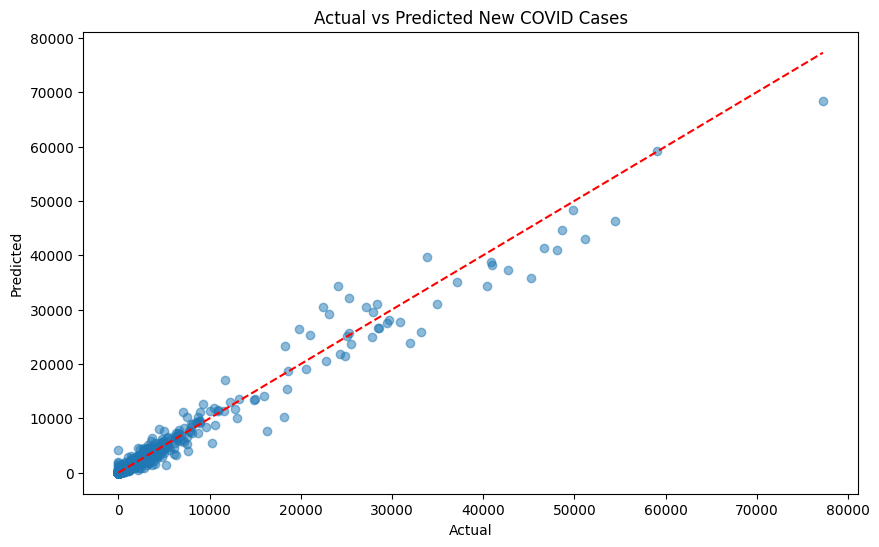

In [192]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(f"R² Score: {r2_score(y_test, predictions):.4f}")
print(f"RMSE: {mean_squared_error(y_test, predictions):.4f}")
print(f"MAE: {mean_absolute_error(y_test, predictions):.4f}")


feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(model.coef_)
})
print("\nFeature Importance:")
print(feature_importance.sort_values('Importance', ascending=False))


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted New COVID Cases')
plt.show()